<a href="https://colab.research.google.com/github/raycmarange/AIML431New/blob/main/assign4_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Starting Task 2 experiments...
Found file at: /content/SMSSpamCollection.txt
Successfully loaded with tab delimiter
Dataset loaded: 5572 samples
Original label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Applying enhanced text preprocessing...


Preprocessing texts:   0%|          | 0/5572 [00:00<?, ?it/s]

After cleaning: 5571 samples
Missing values: label         0
text          0
text_clean    0
dtype: int64
Final dataset size: 5571
Class distribution: {0: 4824, 1: 747}

EXPERIMENT 1: Base BERT with Enhanced Preprocessing + Oversampling

🚀 Starting Base BERT + Preprocessing + Oversampling...
Training samples: 4456, Test samples: 1115
Applying RandomOverSampler to balance the dataset...
Original class distribution: (array([0, 1]), array([3859,  597]))
After oversampling: (array([0, 1]), array([3859, 3859]))
After oversampling - Training samples: 7718
Loading BERT tokenizer and model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing 7718 texts...
✓ Tokenization completed
Tokenizing 1115 texts...
✓ Tokenization completed
Batch size: 16, Total batches: 483
Using standard classifier head
Model moved to cuda
Class weights computed: [1. 1.]

📊 Starting training for 2 epochs...

🎯 Epoch 1/2 started at 03:00:53


Epoch 1/2:   0%|          | 0/483 [00:00<?, ?batch/s]

   Batch 0/483 - Loss: 0.7174
   Batch 10/483 - Loss: 0.4065
   Batch 20/483 - Loss: 0.1460
   Batch 30/483 - Loss: 0.0686
   Batch 40/483 - Loss: 0.0268
   Batch 50/483 - Loss: 0.0130
   Batch 60/483 - Loss: 0.0059
   Batch 70/483 - Loss: 0.1450
   Batch 80/483 - Loss: 0.0258
   Batch 90/483 - Loss: 0.5494
   Batch 100/483 - Loss: 0.0332
   Batch 110/483 - Loss: 0.0097
   Batch 120/483 - Loss: 0.0032
   Batch 130/483 - Loss: 0.1279
   Batch 140/483 - Loss: 0.0035
   Batch 150/483 - Loss: 0.0033
   Batch 160/483 - Loss: 0.0025
   Batch 170/483 - Loss: 0.0052
   Batch 180/483 - Loss: 0.0049
   Batch 190/483 - Loss: 0.2398
   Batch 200/483 - Loss: 0.0187
   Batch 210/483 - Loss: 0.0026
   Batch 220/483 - Loss: 0.1428
   Batch 230/483 - Loss: 0.0111
   Batch 240/483 - Loss: 0.0017
   Batch 250/483 - Loss: 0.0049
   Batch 260/483 - Loss: 0.2762
   Batch 270/483 - Loss: 0.0042
   Batch 280/483 - Loss: 0.1610
   Batch 290/483 - Loss: 0.0376
   Batch 300/483 - Loss: 0.0019
   Batch 310/483 - 

Epoch 2/2:   0%|          | 0/483 [00:00<?, ?batch/s]

   Batch 0/483 - Loss: 0.0004
   Batch 10/483 - Loss: 0.0005
   Batch 20/483 - Loss: 0.0005
   Batch 30/483 - Loss: 0.0003
   Batch 40/483 - Loss: 0.0004
   Batch 50/483 - Loss: 0.0005
   Batch 60/483 - Loss: 0.0004
   Batch 70/483 - Loss: 0.0003
   Batch 80/483 - Loss: 0.0004
   Batch 90/483 - Loss: 0.0005
   Batch 100/483 - Loss: 0.0012
   Batch 110/483 - Loss: 0.0004
   Batch 120/483 - Loss: 0.0003
   Batch 130/483 - Loss: 0.0004
   Batch 140/483 - Loss: 0.0003
   Batch 150/483 - Loss: 0.0003
   Batch 160/483 - Loss: 0.0008
   Batch 170/483 - Loss: 0.0003
   Batch 180/483 - Loss: 0.0003
   Batch 190/483 - Loss: 0.0002
   Batch 200/483 - Loss: 0.0003
   Batch 210/483 - Loss: 0.0002
   Batch 220/483 - Loss: 0.0002
   Batch 230/483 - Loss: 0.0004
   Batch 240/483 - Loss: 0.0003
   Batch 250/483 - Loss: 0.0002
   Batch 260/483 - Loss: 0.0002
   Batch 270/483 - Loss: 0.0002
   Batch 280/483 - Loss: 0.0002
   Batch 290/483 - Loss: 0.0003
   Batch 300/483 - Loss: 0.0002
   Batch 310/483 - 

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

✓ Evaluation completed

🎉 Base BERT + Preprocessing + Oversampling Results:
   Accuracy: 0.9928
   F1-Score: 0.9928
   Total Time: 349.51s
   Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       965
        spam       0.99      0.96      0.97       150

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115


EXPERIMENT 2: BERT with CNN Classifier + Oversampling

🚀 Starting BERT + CNN + Oversampling...
Training samples: 4456, Test samples: 1115
Applying RandomOverSampler to balance the dataset...
Original class distribution: (array([0, 1]), array([3859,  597]))
After oversampling: (array([0, 1]), array([3859, 3859]))
After oversampling - Training samples: 7718
Loading BERT tokenizer and model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing 7718 texts...
✓ Tokenization completed
Tokenizing 1115 texts...
✓ Tokenization completed
Batch size: 16, Total batches: 483
Using CNN classifier on BERT embeddings
Model moved to cuda
Class weights computed: [1. 1.]

📊 Starting training for 2 epochs...

🎯 Epoch 1/2 started at 03:06:33


Epoch 1/2:   0%|          | 0/483 [00:00<?, ?batch/s]

   Batch 0/483 - Loss: 0.6429
   Batch 10/483 - Loss: 0.3641
   Batch 20/483 - Loss: 0.3402
   Batch 30/483 - Loss: 0.0525
   Batch 40/483 - Loss: 0.1002
   Batch 50/483 - Loss: 0.3530
   Batch 60/483 - Loss: 0.0069
   Batch 70/483 - Loss: 0.3532
   Batch 80/483 - Loss: 0.5940
   Batch 90/483 - Loss: 0.0079
   Batch 100/483 - Loss: 0.0046
   Batch 110/483 - Loss: 0.0017
   Batch 120/483 - Loss: 0.0047
   Batch 130/483 - Loss: 0.1604
   Batch 140/483 - Loss: 0.0146
   Batch 150/483 - Loss: 0.0046
   Batch 160/483 - Loss: 0.0077
   Batch 170/483 - Loss: 0.2324
   Batch 180/483 - Loss: 0.0507
   Batch 190/483 - Loss: 0.0747
   Batch 200/483 - Loss: 0.1520
   Batch 210/483 - Loss: 0.0015
   Batch 220/483 - Loss: 0.0015
   Batch 230/483 - Loss: 0.0051
   Batch 240/483 - Loss: 0.0056
   Batch 250/483 - Loss: 0.0020
   Batch 260/483 - Loss: 0.0011
   Batch 270/483 - Loss: 0.0008
   Batch 280/483 - Loss: 0.0007
   Batch 290/483 - Loss: 0.1431
   Batch 300/483 - Loss: 0.0007
   Batch 310/483 - 

Epoch 2/2:   0%|          | 0/483 [00:00<?, ?batch/s]

   Batch 0/483 - Loss: 0.0003
   Batch 10/483 - Loss: 0.0003
   Batch 20/483 - Loss: 0.0002
   Batch 30/483 - Loss: 0.0002
   Batch 40/483 - Loss: 0.0002
   Batch 50/483 - Loss: 0.0024
   Batch 60/483 - Loss: 0.0002
   Batch 70/483 - Loss: 0.0003
   Batch 80/483 - Loss: 0.0002
   Batch 90/483 - Loss: 0.0002
   Batch 100/483 - Loss: 0.0001
   Batch 110/483 - Loss: 0.0002
   Batch 120/483 - Loss: 0.0001
   Batch 130/483 - Loss: 0.0002
   Batch 140/483 - Loss: 0.0028
   Batch 150/483 - Loss: 0.0021
   Batch 160/483 - Loss: 0.0014
   Batch 170/483 - Loss: 0.0002
   Batch 180/483 - Loss: 0.0001
   Batch 190/483 - Loss: 0.0003
   Batch 200/483 - Loss: 0.0003
   Batch 210/483 - Loss: 0.0001
   Batch 220/483 - Loss: 0.0002
   Batch 230/483 - Loss: 0.0003
   Batch 240/483 - Loss: 0.0001
   Batch 250/483 - Loss: 0.0006
   Batch 260/483 - Loss: 0.0002
   Batch 270/483 - Loss: 0.0002
   Batch 280/483 - Loss: 0.0001
   Batch 290/483 - Loss: 0.0001
   Batch 300/483 - Loss: 0.0003
   Batch 310/483 - 

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

✓ Evaluation completed

🎉 BERT + CNN + Oversampling Results:
   Accuracy: 0.9919
   F1-Score: 0.9919
   Total Time: 357.63s
   Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       965
        spam       0.99      0.95      0.97       150

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115


EXPERIMENT 3: DistilBERT + Oversampling

🚀 Starting DistilBERT + Oversampling...
Training samples: 4456, Test samples: 1115
Applying RandomOverSampler to balance the dataset...
Original class distribution: (array([0, 1]), array([3859,  597]))
After oversampling: (array([0, 1]), array([3859, 3859]))
After oversampling - Training samples: 7718
Loading DistilBERT tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing 7718 texts...
✓ Tokenization completed
Tokenizing 1115 texts...
✓ Tokenization completed
Batch size: 16, Total batches: 483
Using standard classifier head
Model moved to cuda
Class weights computed: [1. 1.]

📊 Starting training for 2 epochs...

🎯 Epoch 1/2 started at 03:12:41


Epoch 1/2:   0%|          | 0/483 [00:00<?, ?batch/s]

   Batch 0/483 - Loss: 0.6718
   Batch 10/483 - Loss: 0.3706
   Batch 20/483 - Loss: 0.1442
   Batch 30/483 - Loss: 0.1706
   Batch 40/483 - Loss: 0.2730
   Batch 50/483 - Loss: 0.2898
   Batch 60/483 - Loss: 0.2689
   Batch 70/483 - Loss: 0.0129
   Batch 80/483 - Loss: 0.2758
   Batch 90/483 - Loss: 0.0105
   Batch 100/483 - Loss: 0.0133
   Batch 110/483 - Loss: 0.0130
   Batch 120/483 - Loss: 0.0085
   Batch 130/483 - Loss: 0.0138
   Batch 140/483 - Loss: 0.0099
   Batch 150/483 - Loss: 0.3009
   Batch 160/483 - Loss: 0.0116
   Batch 170/483 - Loss: 0.5622
   Batch 180/483 - Loss: 0.0084
   Batch 190/483 - Loss: 0.0077
   Batch 200/483 - Loss: 0.0085
   Batch 210/483 - Loss: 0.0062
   Batch 220/483 - Loss: 0.0049
   Batch 230/483 - Loss: 0.0074
   Batch 240/483 - Loss: 0.0039
   Batch 250/483 - Loss: 0.3783
   Batch 260/483 - Loss: 0.0044
   Batch 270/483 - Loss: 0.0683
   Batch 280/483 - Loss: 0.2093
   Batch 290/483 - Loss: 0.0039
   Batch 300/483 - Loss: 0.0301
   Batch 310/483 - 

Epoch 2/2:   0%|          | 0/483 [00:00<?, ?batch/s]

   Batch 0/483 - Loss: 0.0014
   Batch 10/483 - Loss: 0.0011
   Batch 20/483 - Loss: 0.0013
   Batch 30/483 - Loss: 0.0017
   Batch 40/483 - Loss: 0.0014
   Batch 50/483 - Loss: 0.0012
   Batch 60/483 - Loss: 0.0010
   Batch 70/483 - Loss: 0.0012
   Batch 80/483 - Loss: 0.0009
   Batch 90/483 - Loss: 0.0008
   Batch 100/483 - Loss: 0.0009
   Batch 110/483 - Loss: 0.0010
   Batch 120/483 - Loss: 0.0067
   Batch 130/483 - Loss: 0.0010
   Batch 140/483 - Loss: 0.0012
   Batch 150/483 - Loss: 0.0882
   Batch 160/483 - Loss: 0.0008
   Batch 170/483 - Loss: 0.0009
   Batch 180/483 - Loss: 0.0011
   Batch 190/483 - Loss: 0.0006
   Batch 200/483 - Loss: 0.0008
   Batch 210/483 - Loss: 0.0007
   Batch 220/483 - Loss: 0.0010
   Batch 230/483 - Loss: 0.0007
   Batch 240/483 - Loss: 0.0005
   Batch 250/483 - Loss: 0.0006
   Batch 260/483 - Loss: 0.0014
   Batch 270/483 - Loss: 0.0005
   Batch 280/483 - Loss: 0.0007
   Batch 290/483 - Loss: 0.0004
   Batch 300/483 - Loss: 0.0006
   Batch 310/483 - 

Evaluating:   0%|          | 0/70 [00:00<?, ?batch/s]

✓ Evaluation completed

🎉 DistilBERT + Oversampling Results:
   Accuracy: 0.9901
   F1-Score: 0.9901
   Total Time: 187.71s
   Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       965
        spam       0.98      0.95      0.96       150

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115


COMPARISON OF ALL EXPERIMENTS
                                 Experiment Accuracy F1-Score  \
0  Base BERT + Preprocessing + Oversampling   0.9928   0.9928   
1                 BERT + CNN + Oversampling   0.9919   0.9919   
2                 DistilBERT + Oversampling   0.9901   0.9901   

  Training Time (s)  
0            349.51  
1            357.63  
2            187.71  


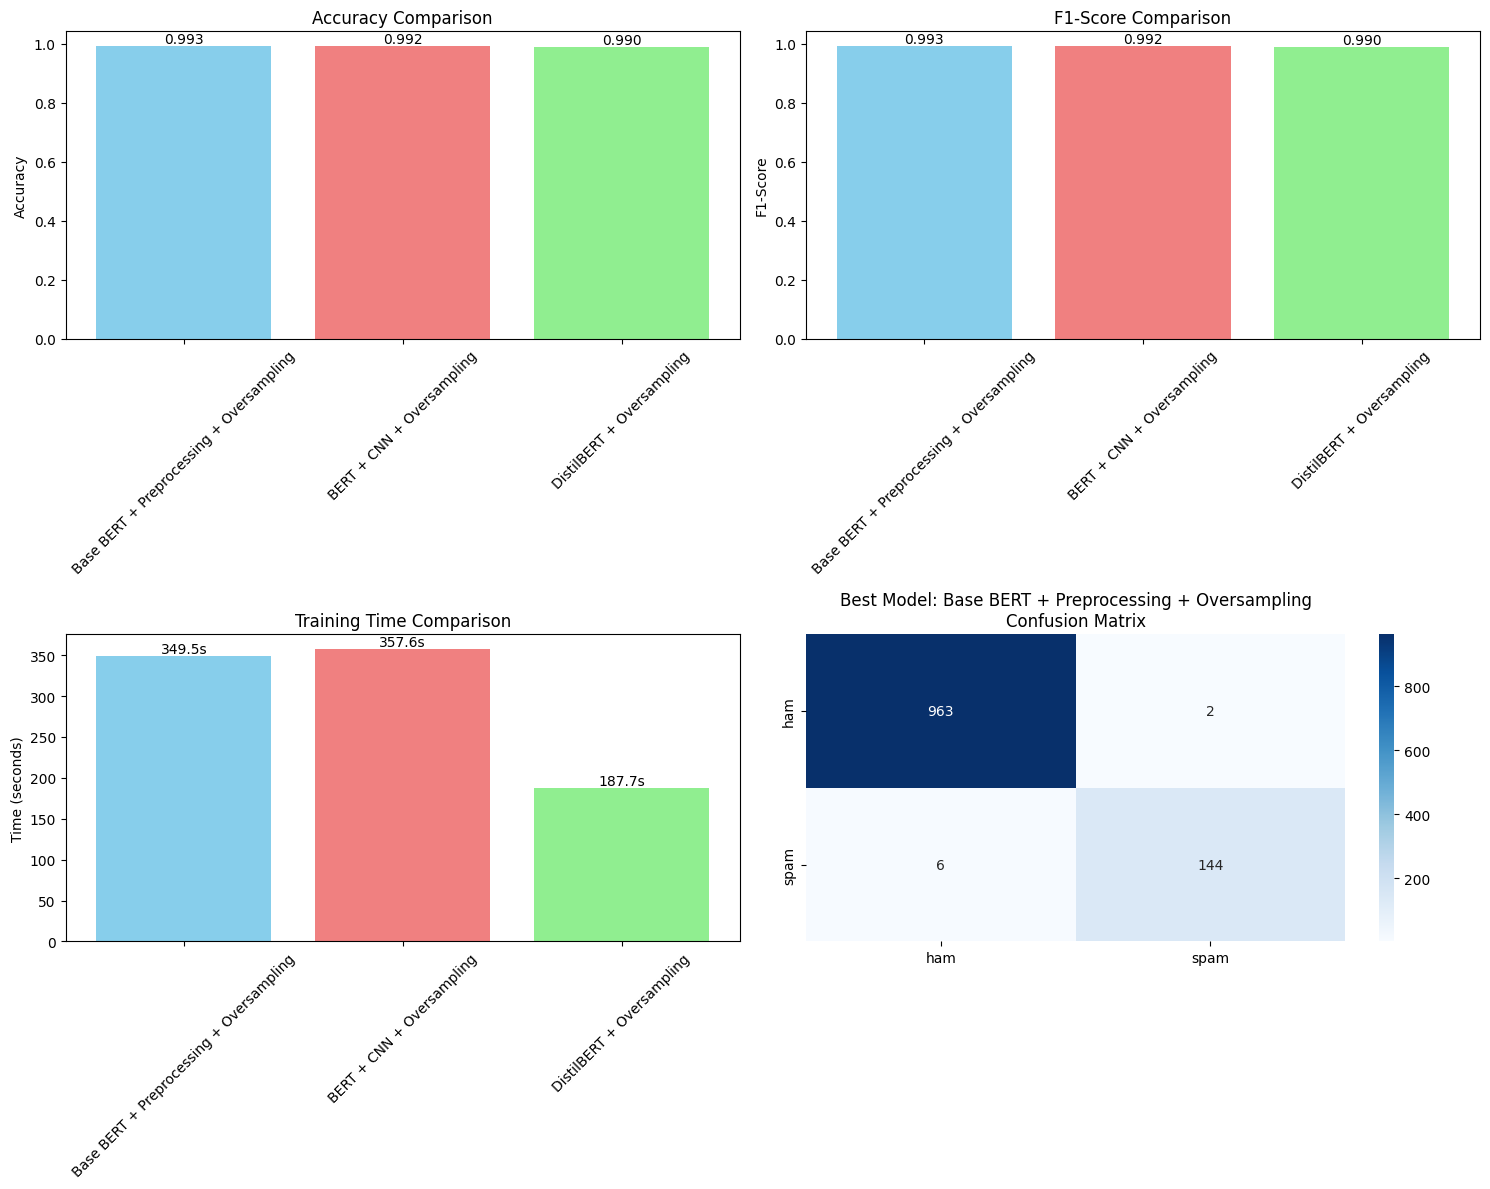


TASK 2 SUMMARY
Experiments completed successfully!

Key improvements attempted in Task 2:
1. Enhanced text preprocessing (cleaning, normalization)
2. RandomOverSampler for dataset balancing
3. CNN classifier on BERT embeddings (alternative to [CLS] token)
4. DistilBERT model for efficiency
5. Class weighting for handling imbalanced data
6. Comprehensive evaluation and comparison

Results saved to 'task2_results.csv'


In [1]:
# assign4-task2.ipynb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tqdm.auto')
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=SyntaxWarning)

import torch
import pandas as pd
import numpy as np
import os
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import torch.nn as nn
from tqdm.auto import tqdm  # Enhanced progress bars
from imblearn.over_sampling import RandomOverSampler  # Added for oversampling

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def balance_dataset(texts, labels):
    """Add oversampling for minority class"""
    print("Applying RandomOverSampler to balance the dataset...")
    print(f"Original class distribution: {np.unique(labels, return_counts=True)}")

    ros = RandomOverSampler(random_state=42)
    texts_reshaped = np.array(texts).reshape(-1, 1)
    texts_resampled, labels_resampled = ros.fit_resample(texts_reshaped, labels)

    print(f"After oversampling: {np.unique(labels_resampled, return_counts=True)}")
    return texts_resampled.flatten(), labels_resampled

# Enhanced preprocessing functions
def enhanced_text_preprocessing(text):
    """Apply additional text preprocessing steps"""
    if pd.isna(text):
        return ""

    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s\.\,\!\?]', '', text)

    # Normalize URLs and numbers (optional - can help with generalization)
    text = re.sub(r'http\S+', '[URL]', text)
    text = re.sub(r'www\.\S+', '[URL]', text)
    text = re.sub(r'\d+', '[NUM]', text)

    return text

def load_and_preprocess_data_enhanced(file_path, apply_preprocessing=True):
    """Enhanced data loading with preprocessing options"""
    try:
        df = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'], encoding='utf-8')
        print("Successfully loaded with tab delimiter")
    except Exception as e:
        print(f"Error with tab delimiter: {e}")
        try:
            df = pd.read_csv(file_path, delimiter=',', header=None, names=['label', 'text'], encoding='utf-8')
            print("Successfully loaded with comma delimiter")
        except Exception as e2:
            print(f"Error with comma delimiter: {e2}")
            # Manual parsing as fallback
            print("Attempting manual file reading...")
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    lines = f.readlines()

                data = []
                for line in lines:
                    parts = line.strip().split('\t', 1)
                    if len(parts) == 2:
                        data.append(parts)
                    else:
                        parts = line.strip().split(' ', 1)
                        if len(parts) == 2:
                            data.append(parts)

                df = pd.DataFrame(data, columns=['label', 'text'])
                print("Successfully loaded with manual parsing")
            except Exception as e3:
                print(f"All loading methods failed: {e3}")
                return None

    if df is None or len(df) == 0:
        print("Failed to load any data")
        return None

    print(f"Dataset loaded: {len(df)} samples")
    print(f"Original label distribution:")
    print(df['label'].value_counts())

    # Enhanced preprocessing
    if apply_preprocessing:
        print("Applying enhanced text preprocessing...")
        # Use tqdm for preprocessing progress
        tqdm.pandas(desc="Preprocessing texts")
        df['text_clean'] = df['text'].progress_apply(enhanced_text_preprocessing)
        # Remove empty texts after cleaning
        df = df[df['text_clean'].str.len() > 0]
        print(f"After cleaning: {len(df)} samples")

    # Convert labels to binary
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})

    # Check for missing values
    print(f"Missing values: {df.isnull().sum()}")
    df = df.dropna()

    return df

def create_sample_dataset():
    """Create sample dataset for testing"""
    print("Creating sample dataset...")

    ham_samples = [
        "Ok lar... Joking wif u oni...",
        "U dun say so early hor... U c already then say...",
        "Nah I don't think he goes to usf, he lives around here though",
        "Hey, are we still meeting for lunch tomorrow?",
        "Can you pick up milk on your way home?",
    ]

    spam_samples = [
        "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
        "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
        "WINNER!! As a valued network customer you have been selected to receive a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.",
        "Urgent! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net 16+",
        "Congratulations! You've been selected for a free iPhone. Click here to claim: http://bit.ly/freeiphone",
    ]

    sample_texts = ham_samples + spam_samples
    sample_labels = [0] * len(ham_samples) + [1] * len(spam_samples)

    return sample_texts, sample_labels

# CNN classifier for BERT embeddings
class CNNClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size=768, num_filters=100, filter_sizes=[3,4,5], num_classes=2, dropout=0.3):
        super(CNNClassifier, self).__init__()
        self.bert = bert_model
        self.convs = nn.ModuleList([
            nn.Conv1d(hidden_size, num_filters, fs) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        # Get BERT outputs
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

        # Apply CNN on the sequence dimension (transpose for Conv1d)
        x = hidden_states.transpose(1, 2)  # [batch_size, hidden_size, seq_len]

        conv_outputs = []
        for conv in self.convs:
            conv_out = torch.relu(conv(x))  # [batch_size, num_filters, seq_len - filter_size + 1]
            pooled = torch.max(conv_out, dim=2)[0]  # [batch_size, num_filters]
            conv_outputs.append(pooled)

        # Concatenate CNN outputs
        cnn_features = torch.cat(conv_outputs, dim=1)  # [batch_size, num_filters * len(filter_sizes)]

        # Classification
        logits = self.classifier(self.dropout(cnn_features))

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits
        return logits

def run_bert_experiment(train_texts, train_labels, test_texts, test_labels,
                       model_type='bert', use_cls=True, use_cnn=False, experiment_name="Experiment",
                       apply_oversampling=True):  # Added oversampling parameter
    """Run a single BERT experiment with given parameters"""

    start_time = time.time()

    print(f"\n🚀 Starting {experiment_name}...")
    print(f"Training samples: {len(train_texts)}, Test samples: {len(test_texts)}")

    # Apply oversampling if requested
    if apply_oversampling and len(np.unique(train_labels)) > 1:
        train_texts, train_labels = balance_dataset(train_texts, train_labels)
        print(f"After oversampling - Training samples: {len(train_texts)}")

    # Select tokenizer and model
    if model_type == 'distilbert':
        print("Loading DistilBERT tokenizer and model...")
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        base_model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased', num_labels=2, output_hidden_states=True
        )
    else:
        print("Loading BERT tokenizer and model...")
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        base_model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', num_labels=2, output_hidden_states=True
        )

    # Tokenize data with progress indication
    def tokenize_data(texts, labels, max_length=128):
        print(f"Tokenizing {len(texts)} texts...")
        if hasattr(texts, 'tolist'):
            texts = texts.tolist()
        elif hasattr(texts, 'values'):
            texts = texts.values.tolist()

        # Show progress for tokenization
        encoded_data = tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        input_ids = encoded_data['input_ids']
        attention_masks = encoded_data['attention_mask']
        labels_tensor = torch.tensor(labels)
        print("✓ Tokenization completed")
        return input_ids, attention_masks, labels_tensor

    train_input_ids, train_attention_masks, train_labels_tensor = tokenize_data(train_texts, train_labels)
    test_input_ids, test_attention_masks, test_labels_tensor = tokenize_data(test_texts, test_labels)

    # Create DataLoaders
    batch_size = min(16, len(train_texts))
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"Batch size: {batch_size}, Total batches: {len(train_dataloader)}")

    # Select model architecture
    if use_cnn and model_type == 'bert':
        model = CNNClassifier(base_model)
        print("Using CNN classifier on BERT embeddings")
    else:
        model = base_model
        print("Using standard classifier head")

    model.to(device)
    print(f"Model moved to {device}")

    # Training setup
    epochs = 2
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Compute class weights for imbalanced data (even with oversampling, weights can help)
    if len(np.unique(train_labels)) > 1:
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        print(f"Class weights computed: {class_weights.cpu().numpy()}")
    else:
        class_weights = None
        print("Single class detected, no class weights applied")

    # Enhanced training loop with progress bars and status checks
    print(f"\n📊 Starting training for {epochs} epochs...")
    model.train()

    for epoch in range(epochs):
        print(f"\n🎯 Epoch {epoch+1}/{epochs} started at {time.strftime('%H:%M:%S')}")
        total_loss = 0
        batch_times = []

        # Create progress bar for batches
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}",
                           unit="batch", leave=True, position=0)

        for batch_num, batch in enumerate(progress_bar):
            batch_start_time = time.time()

            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

            optimizer.zero_grad()

            if use_cnn:
                loss, logits = model(b_input_ids, b_attention_mask, b_labels)
            else:
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss

            # Apply class weights if available and not using CNN
            if class_weights is not None and not use_cnn:
                loss = (loss * class_weights[b_labels]).mean()

            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Calculate batch time and update progress bar
            batch_time = time.time() - batch_start_time
            batch_times.append(batch_time)
            avg_batch_time = np.mean(batch_times[-10:])  # Average of last 10 batches

            # Update progress bar description
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg_batch_time': f'{avg_batch_time:.2f}s'
            })

            # Print status every 10 batches
            if batch_num % 10 == 0:
                print(f"   Batch {batch_num}/{len(train_dataloader)} - Loss: {loss.item():.4f}")

        # Epoch completion
        avg_loss = total_loss / len(train_dataloader)
        epoch_time = time.time() - start_time
        print(f"✅ Epoch {epoch+1}/{epochs} completed at {time.strftime('%H:%M:%S')}")
        print(f"   Average Loss: {avg_loss:.4f}")
        print(f"   Epoch Time: {epoch_time:.2f}s")
        print(f"   Still running... Preparing next epoch" if epoch < epochs - 1 else "   Training completed!")

    # Enhanced evaluation with progress indication
    print(f"\n📈 Starting evaluation...")
    model.eval()
    predictions, true_labels = [], []

    eval_progress = tqdm(test_dataloader, desc="Evaluating", unit="batch")

    for batch in eval_progress:
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            if use_cnn:
                logits = model(b_input_ids, b_attention_mask)
            else:
                outputs = model(b_input_ids, attention_mask=b_attention_mask)
                logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

    print("✓ Evaluation completed")

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    if len(np.unique(true_labels)) > 1:
        f1 = f1_score(true_labels, predictions, average='weighted')
    else:
        f1 = 1.0 if accuracy == 1.0 else 0.0

    total_time = time.time() - start_time

    print(f"\n🎉 {experiment_name} Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Total Time: {total_time:.2f}s")

    if len(np.unique(true_labels)) > 1:
        print("   Classification Report:")
        print(classification_report(true_labels, predictions, target_names=['ham', 'spam']))
    else:
        print("   Only one class present in test set")

    return {
        'name': experiment_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'training_time': total_time,
        'predictions': predictions,
        'true_labels': true_labels
    }

def plot_comparison(results):
    """Plot comparison of different experiments"""
    if not results:
        print("No results to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    # Accuracy comparison
    names = [results[exp]['name'] for exp in results]
    accuracies = [results[exp]['accuracy'] for exp in results]

    bars1 = axes[0].bar(names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0].set_title('Accuracy Comparison')
    axes[0].set_ylabel('Accuracy')
    axes[0].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')

    # F1-score comparison
    f1_scores = [results[exp]['f1_score'] for exp in results]
    bars2 = axes[1].bar(names, f1_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[1].set_title('F1-Score Comparison')
    axes[1].set_ylabel('F1-Score')
    axes[1].tick_params(axis='x', rotation=45)

    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')

    # Training time comparison
    times = [results[exp]['training_time'] for exp in results]
    bars3 = axes[2].bar(names, times, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[2].set_title('Training Time Comparison')
    axes[2].set_ylabel('Time (seconds)')
    axes[2].tick_params(axis='x', rotation=45)

    for bar in bars3:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}s', ha='center', va='bottom')

    # Confusion matrix for the best experiment
    best_exp = max(results.keys(), key=lambda x: results[x]['accuracy'])
    cm = confusion_matrix(results[best_exp]['true_labels'], results[best_exp]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[3], cmap='Blues',
               xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    axes[3].set_title(f'Best Model: {results[best_exp]["name"]}\nConfusion Matrix')

    plt.tight_layout()
    plt.show()

# Main execution function
def run_task2_experiments():
    """Run different experiments for Task 2"""

    # Get the current directory
    current_dir = os.getcwd()

    # Try different possible file paths
    possible_paths = [
        "SMSSpamCollection",
        "./SMSSpamCollection",
        "/content/SMSSpamCollection.txt",
        "./SMSSpamCollection.txt",
        os.path.join(current_dir, "SMSSpamCollection"),
        os.path.join(current_dir, "SMSSpamCollection.txt"),
    ]

    file_path = None
    for path in possible_paths:
        if os.path.exists(path):
            file_path = path
            print(f"Found file at: {path}")
            break

    if file_path is None:
        print("SMSSpamCollection file not found. Using sample dataset.")
        sample_texts, sample_labels = create_sample_dataset()
        df = pd.DataFrame({'text': sample_texts, 'label': sample_labels})
        df['text_clean'] = df['text']
    else:
        # Load with enhanced preprocessing
        df = load_and_preprocess_data_enhanced(file_path, apply_preprocessing=True)
        if df is None or len(df) == 0:
            print("Failed to load dataset, using sample data instead")
            sample_texts, sample_labels = create_sample_dataset()
            df = pd.DataFrame({'text': sample_texts, 'label': sample_labels})
            df['text_clean'] = df['text']

    print(f"Final dataset size: {len(df)}")
    print(f"Class distribution: {df['label'].value_counts().to_dict()}")

    # Use cleaned text if available
    text_column = 'text_clean' if 'text_clean' in df.columns else 'text'

    # Split data
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df[text_column].values, df['label'].values, test_size=0.2, random_state=42, stratify=df['label']
    )

    results = {}

    # Experiment 1: Base BERT with enhanced preprocessing and oversampling
    print("\n" + "="*60)
    print("EXPERIMENT 1: Base BERT with Enhanced Preprocessing + Oversampling")
    print("="*60)

    results['exp1'] = run_bert_experiment(
        train_texts, train_labels, test_texts, test_labels,
        model_type='bert', use_cls=True, use_cnn=False,
        experiment_name="Base BERT + Preprocessing + Oversampling",
        apply_oversampling=True
    )

    # Experiment 2: BERT with CNN classifier and oversampling
    print("\n" + "="*60)
    print("EXPERIMENT 2: BERT with CNN Classifier + Oversampling")
    print("="*60)

    results['exp2'] = run_bert_experiment(
        train_texts, train_labels, test_texts, test_labels,
        model_type='bert', use_cls=False, use_cnn=True,
        experiment_name="BERT + CNN + Oversampling",
        apply_oversampling=True
    )

    # Experiment 3: DistilBERT with oversampling
    print("\n" + "="*60)
    print("EXPERIMENT 3: DistilBERT + Oversampling")
    print("="*60)

    results['exp3'] = run_bert_experiment(
        train_texts, train_labels, test_texts, test_labels,
        model_type='distilbert', use_cls=True, use_cnn=False,
        experiment_name="DistilBERT + Oversampling",
        apply_oversampling=True
    )

    # Compare results
    print("\n" + "="*60)
    print("COMPARISON OF ALL EXPERIMENTS")
    print("="*60)

    comparison_data = []
    for exp_key in results:
        exp = results[exp_key]
        comparison_data.append({
            'Experiment': exp['name'],
            'Accuracy': f"{exp['accuracy']:.4f}",
            'F1-Score': f"{exp['f1_score']:.4f}",
            'Training Time (s)': f"{exp['training_time']:.2f}"
        })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df)

    # Visualization
    plot_comparison(results)

    return results, comparison_df

# Run the experiments
print("Starting Task 2 experiments...")
results, comparison_df = run_task2_experiments()

# Print summary
print("\n" + "="*60)
print("TASK 2 SUMMARY")
print("="*60)
print("Experiments completed successfully!")
print("\nKey improvements attempted in Task 2:")
print("1. Enhanced text preprocessing (cleaning, normalization)")
print("2. RandomOverSampler for dataset balancing")
print("3. CNN classifier on BERT embeddings (alternative to [CLS] token)")
print("4. DistilBERT model for efficiency")
print("5. Class weighting for handling imbalanced data")
print("6. Comprehensive evaluation and comparison")

# Save results for report
comparison_df.to_csv('task2_results.csv', index=False)
print("\nResults saved to 'task2_results.csv'")